<a href="https://colab.research.google.com/github/Savvythelegend/MLE/blob/main/from_scratch/sklearn_ensemble_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### RF = bagging + Row level sampling + column level sampling

---


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
print(clf.predict([[0, 0, 0, 0]]))

[1]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# 1000 samples, 4 features
X, y = make_regression(n_samples=1000, n_features=4, noise=0.2, random_state=0)

# Initialize regressor
reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=4, # contorls the overfitting
    random_state=0
)

# Train
reg.fit(X, y)

# Predict for one sample
print(reg.predict([[0, 0, 0, 0]]))   # e.g. array([-0.05])

# R² score on training data
print(reg.score(X, y))  # close to 1 if model fits well

[50.36307572]
0.8292288531718314


In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# load dataset
iris = load_iris()
X = iris.data
y = iris.target

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

# train
rf = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 2,
    random_state = 42
)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

# predict
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Combine predictors using stacking

Stacking refers to a method to blend estimators. In this strategy, some estimators are individually fitted on some training data while a final estimator is trained using the stacked predictions of these base estimators.

In this example, we illustrate the use case in which different regressors are stacked together and a final linear penalized regressor is used to output the prediction. We compare the performance of each individual regressor with the stacking strategy. Stacking slightly improves the overall performance.

In [1]:
"""The Ames housing dataset is not shipped with scikit-learn and therefore we will fetch it from OpenML."""
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle


def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]

    X = X.loc[:, features]
    X, y = shuffle(X, y, random_state=0)

    X = X.iloc[:600]
    y = y.iloc[:600]
    return X, np.log(y)


X, y = load_ames_housing()

### Make pipeline to preprocess the data

In [5]:
"""Before we can use Ames dataset we still need to do some preprocessing. First, we will select the categorical and numerical columns of the dataset to construct the first step of the pipeline."""

from sklearn.compose import make_column_selector
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
num_selector(X)

['YrSold',
 'YearRemodAdd',
 'BsmtUnfSF',
 'MasVnrArea',
 'MSSubClass',
 'GarageCars',
 'OverallQual',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'MoSold']

In [6]:
"""Then, we will need to design preprocessing pipelines which depends on the ending regressor. If the ending regressor is a linear model, one needs to one-hot encode the categories. If the ending regressor is a tree-based model an ordinal encoder will be sufficient. Besides, numerical values need to be standardized for a linear model while the raw numerical data can be treated as is by a tree-based model. However, both models need an imputer to handle missing values."""

'Then, we will need to design preprocessing pipelines which depends on the ending regressor. If the ending regressor is a linear model, one needs to one-hot encode the categories. If the ending regressor is a tree-based model an ordinal encoder will be sufficient. Besides, numerical values need to be standardized for a linear model while the raw numerical data can be treated as is by a tree-based model. However, both models need an imputer to handle missing values.'

In [8]:
#We will first design the pipeline required for the tree-based models.

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dda18ac1b20>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dda11bbf950>)])

In [9]:
"""Then, we will now define the preprocessor used when the ending regressor is a linear model."""
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dda18ac1b20>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dda11bbf950>)])

### Stack of predictors on a single data set
It is sometimes tedious to find the model which will best perform on a given dataset. Stacking provide an alternative by combining the outputs of several learners, without the need to choose a model specifically. The performance of stacking is usually close to the best model and sometimes it can outperform the prediction performance of each individual model.

Here, we combine 3 learners (linear and non-linear) and use a ridge regressor to combine their outputs together

In [10]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dda18ac1b20>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dda11bbf950>)])),
                ('lassocv', LassoCV())])

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dda18ac1b20>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dda11bbf950>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dda18ac1b20>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dda11bbf950>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

In [13]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dda18ac1b20>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_v...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dda18ac1b20>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dda11bbf950>)])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())

### Measure and plot the results
Now we can use Ames Housing dataset to make the predictions. We check the performance of each individual predictor as well as of the stack of the regressors.

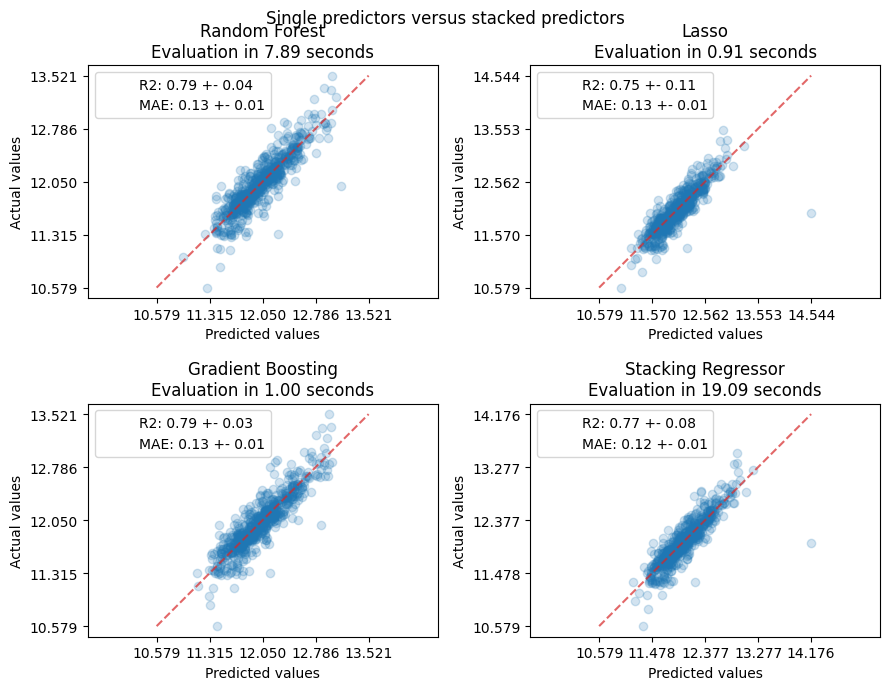

In [14]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

#### Summary:

The stacked regressor will combine the strengths of the different regressors. However, we also see that training the stacked regressor is much more computationally expensive.

*Total running time of the script: (0 minutes 23.650 seconds)*

Random Forest and Gradient Boosting delivered strong results cheaply, while stacking burned time only to add no real value. *mfck 😡